<a href="https://colab.research.google.com/github/BartoszMietlicki/kaggle-heart-disease-s6e2/blob/main/BM_HeartDisease_S6E2_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
`Author:` Bartosz Mietlicki

`Date of completion:` Feb 2026

`Competition page:` https://www.kaggle.com/competitions/playground-series-s6e2

---
<img src="https://i.postimg.cc/9FZqskQn/Screenshot-1.png" style="width:100%; max-width:1200px; display:block; margin: 0 auto;">

___
## **0 –  Introduction and Project Assumptions**
___


### **0.1 - Project overview**

This notebook builds a binary classification model for the Kaggle Playground Series (S6E2).  
The goal is to predict the probability of the positive class (`target = 1`) for the competition test set and generate a valid submission file.

The modeling pipeline evaluates three model families under the same cross-validation strategy and metric:
- Logistic Regression (baseline, linear model)
- XGBoost (gradient-boosted trees)
- TabNet (neural network for tabular data)

The final submission model is selected based on cross-validated ROC AUC and practicality (training time vs performance).

___
### **0.2 - Table of Contents**

- **0 — Introduction and Project Assumptions**
  - 0.1 Project overview  
  - 0.2 Table of Contents
  - 0.3 Data  
  - 0.4 How to use this notebook  

- **1 — Environment Setup and Data Import**
  - 1.1 Environment setup  
  - 1.2 Data importing  
    - 1.2a Data Importing (Kaggle)
    - 1.2b Data Importing (Colab)
  - 1.3 Data check  

- **2 — Exploratory Data Analysis**
  - 2.1 Target analysis  
  - 2.2 Numeric feature distributions  
  - 2.3 Categorical feature overview  
  - 2.4 Feature–target relationships  
    - 2.4.1 Continuous features vs target
    - 2.4.2 Categorical features vs target
  - 2.5 EDA summary  

- **3 — Modeling & Hyperparameter Tuning**
  - 3.1 Shared setup  
  - 3.2 Logistic Regression  
  - 3.3 XGBoost  
  - 3.4 TabNet  
  - 3.5 Model comparison & selection  

- **4 — Final Model**
  - 4.1 Training  
  - 4.2 Predictions  

- **5 — Submission (Kaggle only)**


___
### **0.3 - Data**

- ### Kaggle description:

"*The dataset used in this competition (both train and test) was generated by a deep learning model trained on an original heart disease prediction dataset. Feature distributions are close to, but not exactly the same as, the original dataset. The original dataset can be used to explore potential distribution differences and, optionally, to test whether incorporating additional data improves model performance."*


- ### Original dataset:

https://www.kaggle.com/datasets/neurocipher/heartdisease/data

- ### Feature legend

The table below summarizes the meaning of each column used in this notebook.

| Feature | Description | Notes / Typical coding |
|---|---|---|
| id | Unique row identifier | Not a predictive feature (identifier only). |
| Age | Age of the patient (years) | Continuous. |
| Sex | Sex of the patient | Common encoding: `1 = male`, `0 = female`. |
| Chest pain type | Type of chest pain | Integer-coded categories (treat as categorical). Exact label mapping may depend on the source dataset. |
| BP | Resting blood pressure (mm Hg) | Continuous. |
| Cholesterol | Serum cholesterol (mg/dl) | Continuous; may contain outliers. |
| FBS over 120 | Fasting blood sugar > 120 mg/dl | Binary: `1 = yes`, `0 = no`. |
| EKG results | Resting electrocardiogram results | Integer-coded categories (treat as categorical). |
| Max HR | Maximum heart rate achieved | Continuous. |
| Exercise angina | Exercise-induced angina | Binary: `1 = yes`, `0 = no`. |
| ST depression | ST depression induced by exercise relative to rest | Continuous; often right-skewed. |
| Slope of ST | Slope of the peak exercise ST segment | Integer-coded categories (treat as categorical). Common coding: `1 = upsloping`, `2 = flat`, `3 = downsloping`. |
| Number of vessels fluro | Number of major vessels colored by fluoroscopy | Discrete values (often `0–3`), treat as categorical/ordinal. |
| Thallium | Thallium stress test result | Integer-coded categories (treat as categorical). Common coding: `3 = normal`, `6 = fixed defect`, `7 = reversible defect`. |
| Heart Disease | Target label (presence/absence of heart disease) | Present only in `train`. In this notebook it remains as labels (e.g., `Presence` / `Absence`) until preprocessing. |

___
### **0.4 - How to Use This Notebook (Kaggle & Colab)**

This notebook is designed to run in **either Kaggle Notebooks or Google Colab**. The only difference is **how the data is accessed**.

 `Run on Kaggle`
- Use **Cell 1.2a (Kaggle)** to load data from `/kaggle/input/...`
- Keep **Cell 1.2b (Colab)** commented out

 `Run on Colab`
- Use **Cell 1.2b (Colab)** to download data via Kaggle CLI
- Keep **Cell 1.2a (Kaggle)** commented out
- You need a Kaggle **API Token** stored in **Colab Secrets** as `KAGGLE_TOKEN`
- Make sure you have clicked **Join Competition / accepted rules** in Kaggle to avoid access errors

___
## **1 – Environment Setup and Data Importing**
___


### **1.1 - Environment Setup**

In [25]:
!pip -q install pytorch-tabnet==4.1.0 tqdm-joblib

import os, subprocess, pathlib, zipfile
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, PercentFormatter

from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid

from xgboost import XGBClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

plt.style.use("seaborn-v0_8-whitegrid")
PALETTE_FLARE = sns.color_palette("flare")
K_FORMATTER = FuncFormatter(lambda x, _: f"{x/1000:.0f}K" if x >= 1000 else f"{int(x)}")

___
### **1.2 - Data Importing**

___
#### **1.2a - Data Importing (Kaggle)**

In [3]:
# COMP = "playground-series-s6e2"
# train = pd.read_csv(f"/kaggle/input/{COMP}/train.csv")
# test  = pd.read_csv(f"/kaggle/input/{COMP}/test.csv")

# print("Shapes:", "train", train.shape, "| test", test.shape)

___
#### **1.2b - Data Importing (Colab)**

In [4]:
from google.colab import userdata

subprocess.run(["pip","-q","install","--no-cache-dir","--force-reinstall","kaggle==1.8.3"], check=True)
subprocess.run(["pip","-q","install","--no-cache-dir","--force-reinstall","kagglesdk==0.1.15"], check=True)

os.environ["KAGGLE_API_TOKEN"] = userdata.get("KAGGLE_TOKEN")

COMP = "playground-series-s6e2"
DATA_DIR = pathlib.Path(f"/content/data/{COMP}")
DATA_DIR.mkdir(parents=True, exist_ok=True)

subprocess.run(["kaggle","competitions","download","-c",COMP,"-p",str(DATA_DIR),"--force"], check=True)
zipfile.ZipFile(next(DATA_DIR.glob("*.zip"))).extractall(DATA_DIR)

train = pd.read_csv(DATA_DIR / "train.csv")
test  = pd.read_csv(DATA_DIR / "test.csv")

print("Shapes:", "train", train.shape, "| test", test.shape)

Shapes: train (630000, 15) | test (270000, 14)


___
### **1.3 - Data Check**


In [5]:
print("===== TRAIN =====")
display(train.head(3))
print()
train.info()

print("\n===== TEST =====")
display(test.head(3))
print()
test.info()

===== TRAIN =====


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hea

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       270000 non-null  int64  
 1   Age                      270000 non-null  int64  
 2   Sex                      270000 non-null  int64  
 3   Chest pain type          270000 non-null  int64  
 4   BP                       270000 non-null  int64  
 5   Cholesterol              270000 non-null  int64  
 6   FBS over 120             270000 non-null  int64  
 7   EKG results              270000 non-null  int64  
 8   Max HR                   270000 non-null  int64  
 9   Exercise angina          270000 non-null  int64  
 10  ST depression            270000 non-null  float64
 11  Slope of ST              270000 non-null  int64  
 12  Number of vessels fluro  270000 non-null  int64  
 13  Thallium                 270000 non-null  int64  
dtypes: 

**Summary:**

The dataset contains 900,000 observations split into 630,000 rows in train and 270,000 rows in test.  
train has 15 columns while test has 14 columns — the difference is the target column Heart Disease, which is present only in train.  

Both datasets are complete (no missing values). All feature columns are stored as numeric types mostly int64, with ST depression as float64. The target Heart Disease is currently stored as an **object** type (categorical labels such as Presence/Absence), which will be mapped to a numeric representation for modeling.

___
## **2 – Exploratory Data Analysis**
___


### **2.1 - Target analysis**


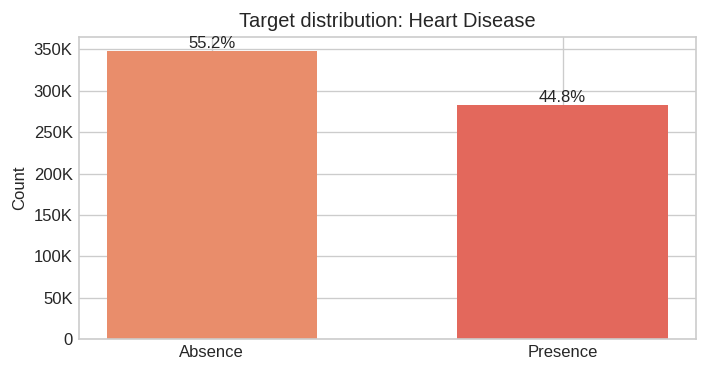

In [6]:
counts = train["Heart Disease"].value_counts()
perc = counts / counts.sum()

fig, ax = plt.subplots(figsize=(6, 3.2), dpi=120)
bars = ax.bar(counts.index, counts.values, color=PALETTE_FLARE[:2], width=0.6)

ax.set_title("Target distribution: Heart Disease")
ax.set_ylabel("Count")
ax.yaxis.set_major_formatter(K_FORMATTER)

for b, p in zip(bars, perc.values):
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{p:.1%}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

**Summary:**

The target is binary and shows a mild class imbalance (Absence ~55% vs Presence ~45%). This is not severe enough to be a major issue on its own, but it is worth keeping in mind during model training and validation to ensure the evaluation remains representative.


___
### **2.2 - Numeric feature distributions**


In [7]:
TARGET = "Heart Disease"
CAT_UNIQUE_MAX = 10

features = train.drop(columns=["id", TARGET])
nuniq = features.nunique()

cat_cols = nuniq[nuniq <= CAT_UNIQUE_MAX].index.tolist()
num_cols = [c for c in features.columns if c not in cat_cols]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Numeric features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
Categorical features: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


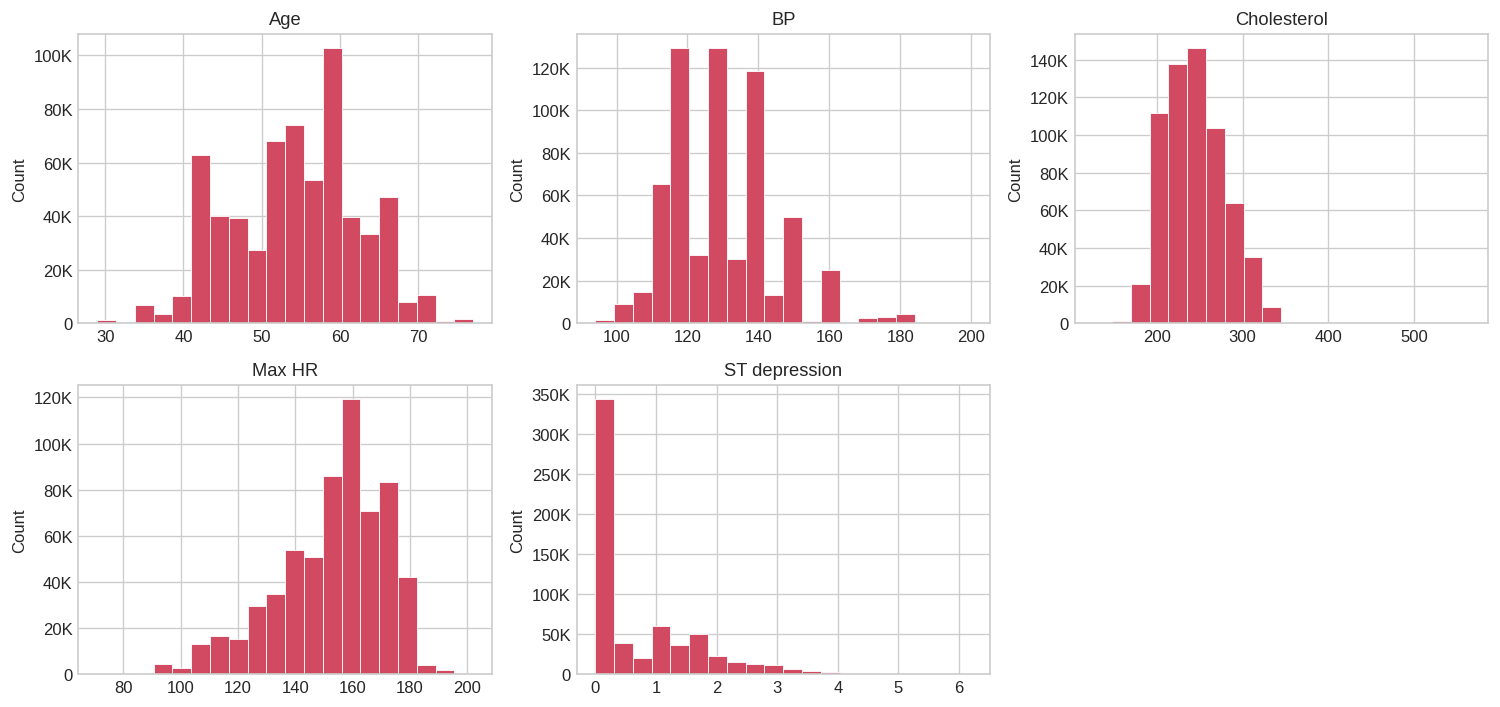

In [8]:
import math
import numpy as np

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.0), dpi=120)
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, num_cols):
    ax.hist(train[col], bins=20, color=PALETTE_FLARE[2], edgecolor="white", linewidth=0.5)
    ax.set_title(col, fontsize=11)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_formatter(K_FORMATTER)

for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


**Summary:**

The continuous features (Age, BP, Cholesterol, Max HR, ST depression) show reasonable ranges and mostly unimodal distributions. ST depression is clearly right-skewed with a heavy concentration near zero and a long tail, which suggests potential sensitivity to scaling and outliers in some models.

___
### **2.3 - Categorical feature distributions**


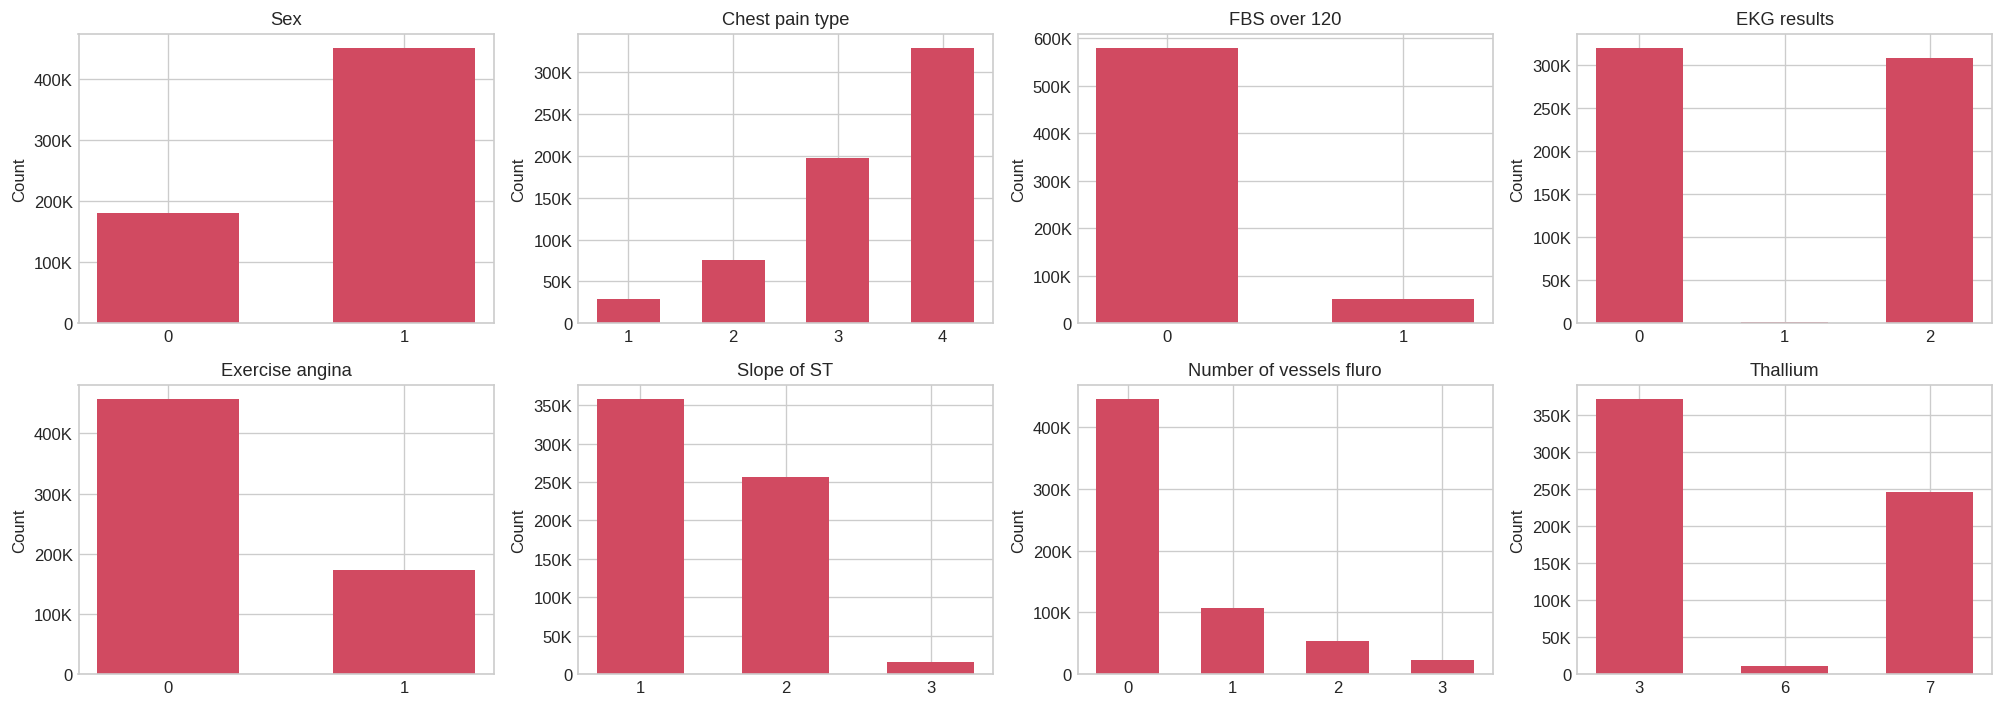

In [9]:
n = len(cat_cols)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.0), dpi=120)
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, cat_cols):
    vc = train[col].value_counts().sort_index()
    ax.bar(vc.index.astype(str), vc.values, color=PALETTE_FLARE[2], width=0.6)
    ax.set_title(col, fontsize=11)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_formatter(K_FORMATTER)

for ax in axes[len(cat_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

**Summary:**

Most remaining features behave as categorical/binary codes rather than continuous measurements (e.g., Sex, FBS over 120, Exercise angina, Chest pain type, EKG results, Slope of ST, Number of vessels fluro, Thallium). Several of these variables are highly imbalanced across categories and include rare levels, which should be considered later when choosing an encoding strategy and validating model stability.

___
### **2.4 - Feature–target relationships**


___
#### **2.4.1 - Continuous features vs target**


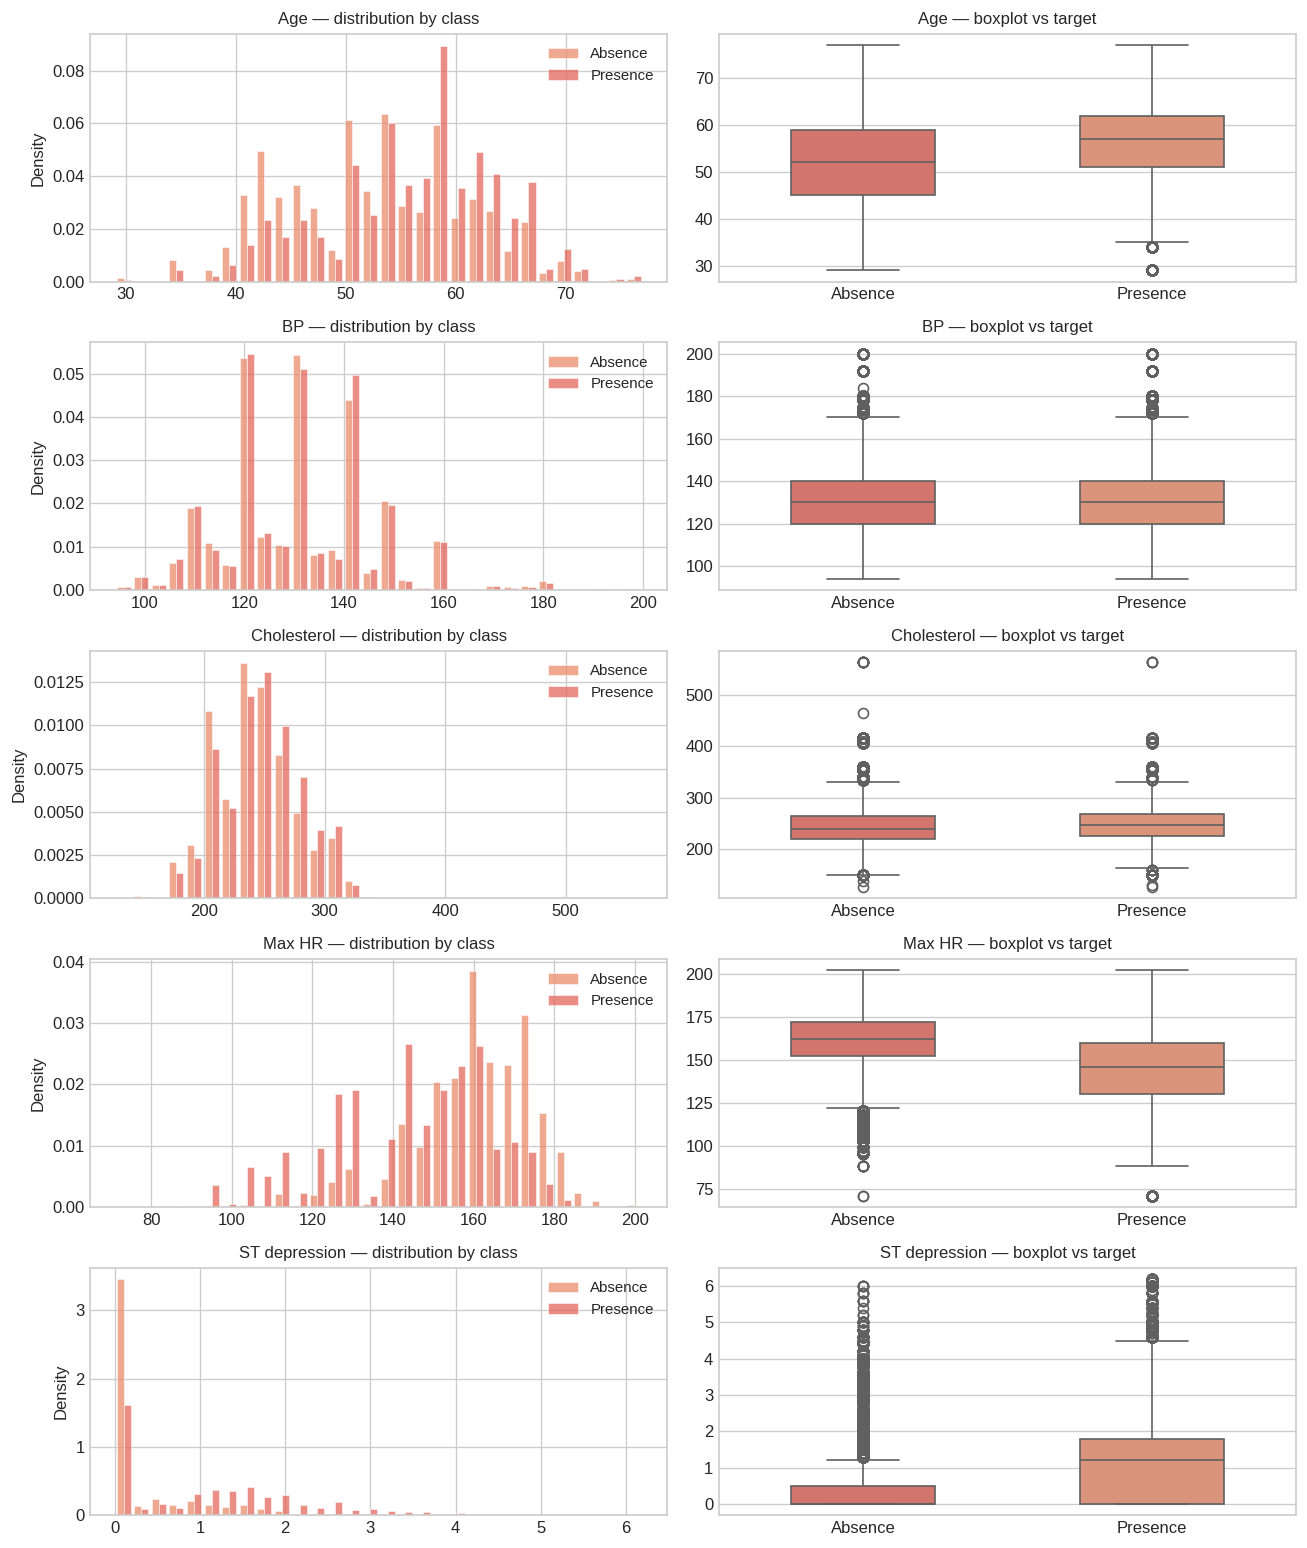

In [10]:
POS_LABEL = "Presence"
y_bin = (train[TARGET] == POS_LABEL).astype(int)

fig, axes = plt.subplots(len(num_cols), 2, figsize=(11, 2.6*len(num_cols)), dpi=120)

for i, col in enumerate(num_cols):
    ax_l, ax_r = axes[i, 0], axes[i, 1]

    # (a) Class-conditional distributions
    x0 = train.loc[y_bin == 0, col]
    x1 = train.loc[y_bin == 1, col]
    ax_l.hist([x0, x1], bins=30, density=True, alpha=0.75,
              color=[PALETTE_FLARE[0], PALETTE_FLARE[1]], label=["Absence", "Presence"],
              edgecolor="white", linewidth=0.4)
    ax_l.set_title(f"{col} — distribution by class", fontsize=10)
    ax_l.set_ylabel("Density")
    ax_l.legend(frameon=False, fontsize=9)

    # (b) Boxplot vs target
    sns.boxplot(data=train, x=TARGET, y=col, order=["Absence", "Presence"], hue=TARGET,
                palette=[PALETTE_FLARE[0], PALETTE_FLARE[1]], ax=ax_r, width=0.5, legend=False)
    ax_r.set_title(f"{col} — boxplot vs target", fontsize=10)
    ax_r.set_xlabel("")
    ax_r.set_ylabel("")

plt.tight_layout()
plt.show()

In [11]:
rows = []
for col in num_cols:
    auc = roc_auc_score(y_bin, train[col])
    strength = max(auc, 1 - auc)
    direction = "higher → Presence" if auc >= 0.5 else "lower → Presence"
    rows.append({"feature": col, "AUC": auc, "AUC_strength": strength, "direction": direction})

display(pd.DataFrame(rows).sort_values("AUC_strength", ascending=False))

,feature,AUC,AUC_strength,direction
3,Max HR,0.244092,0.755908,lower → Presence
4,ST depression,0.733678,0.733678,higher → Presence
0,Age,0.625654,0.625654,higher → Presence
2,Cholesterol,0.552904,0.552904,higher → Presence
1,BP,0.500486,0.500486,higher → Presence


**Summary:**

Among continuous features, Max HR and ST depression show the strongest separation between classes. Lower Max HR is strongly associated with Presence, while higher ST depression is associated with Presence and exhibits a highly right-skewed distribution (mass near zero with a long tail), which may require attention for scale-sensitive models. Age shows a moderate positive relationship with Presence, Cholesterol provides only weak standalone signal with notable outliers, and BP appears close to non-informative as a univariate predictor (AUC ~ 0.50).


___
#### **2.4.2 - Categorical features vs target**


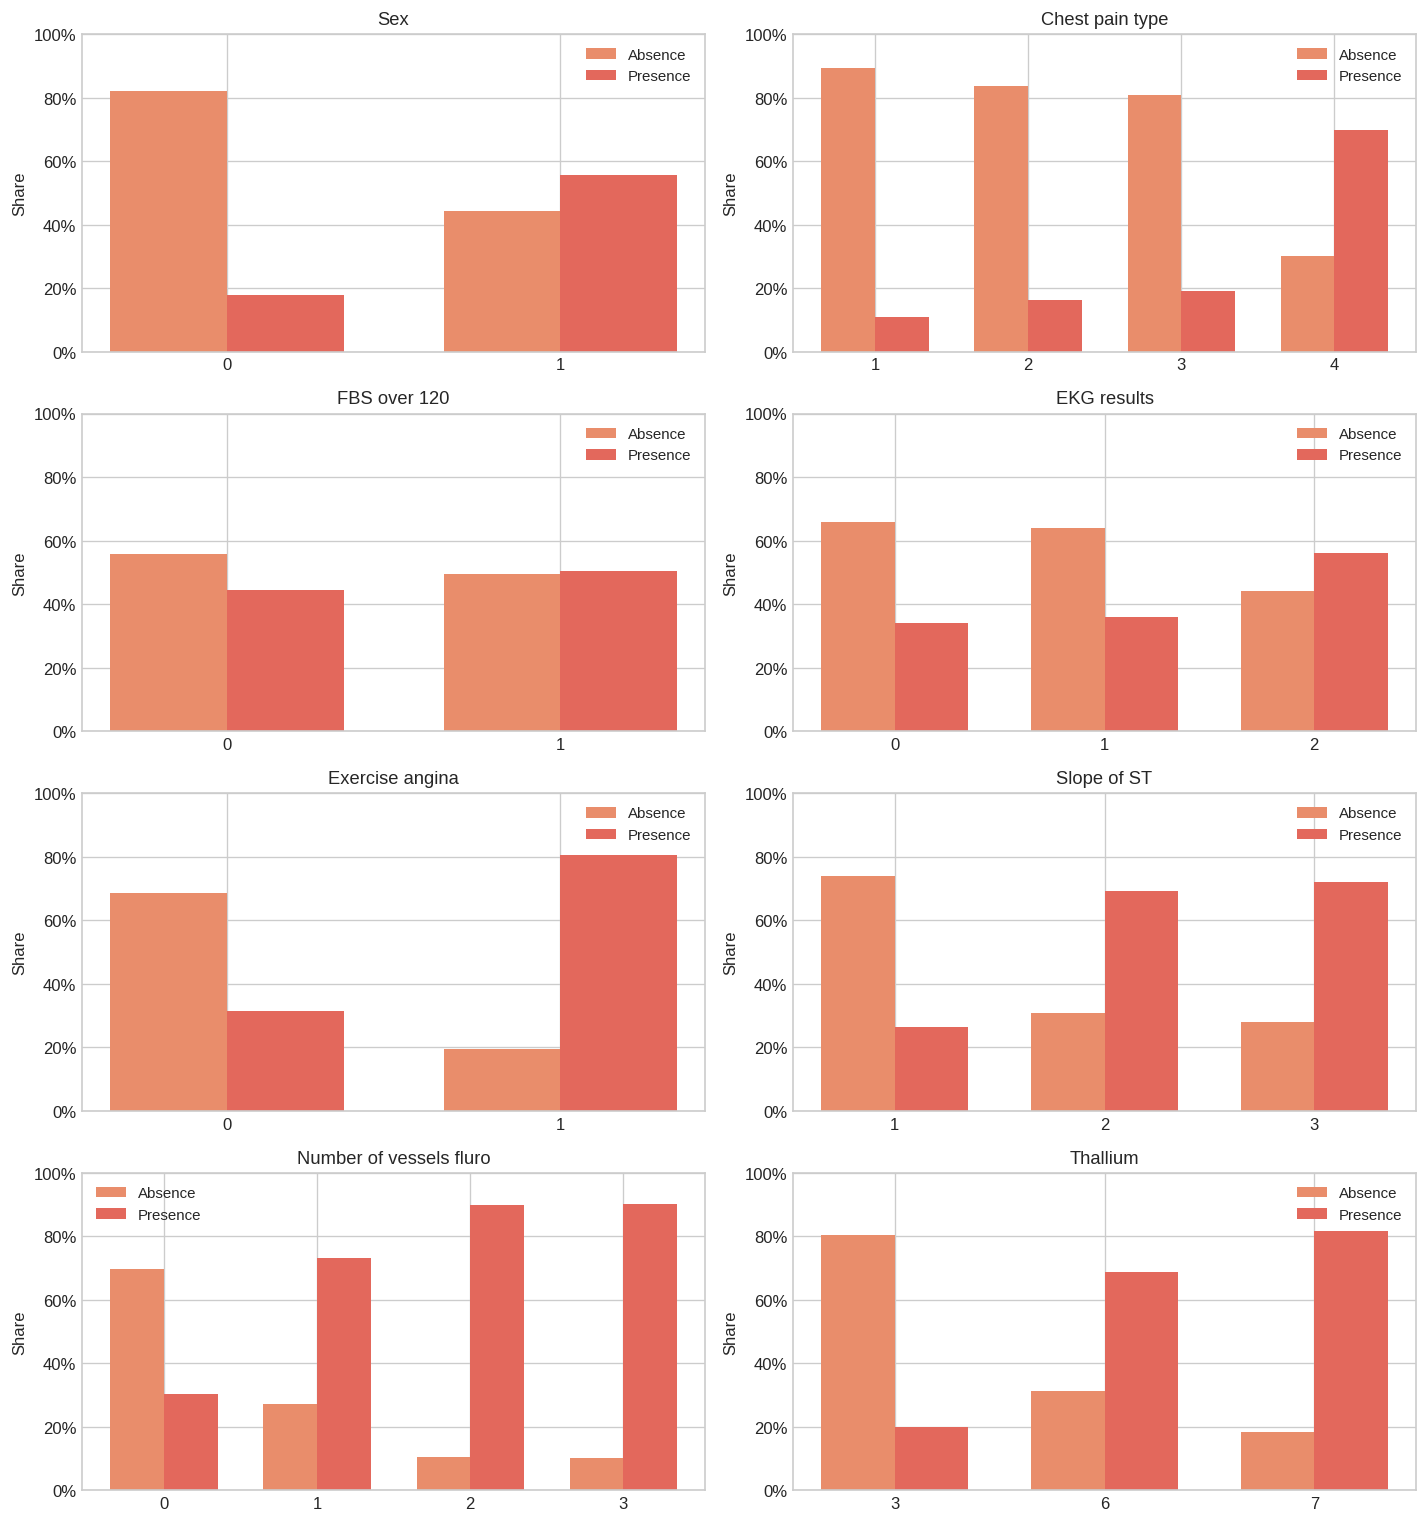

In [12]:
fig, axes = plt.subplots(
    math.ceil(len(cat_cols) / 2), 2,
    figsize=(12, 3.2 * math.ceil(len(cat_cols) / 2)),
    dpi=120
)
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, cat_cols):
    ct = pd.crosstab(train[col], train[TARGET]).reindex(columns=["Absence", "Presence"], fill_value=0)
    ct = ct.sort_index()
    prop = ct.div(ct.sum(axis=1), axis=0)

    x = np.arange(len(ct.index))
    w = 0.35

    ax.bar(x - w/2, prop["Absence"], width=w, color=PALETTE_FLARE[0], label="Absence")
    ax.bar(x + w/2, prop["Presence"], width=w, color=PALETTE_FLARE[1], label="Presence")

    ax.set_title(f"{col}", fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(ct.index.astype(str))
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_ylabel("Share")
    ax.legend(frameon=False, fontsize=9)

for ax in axes[len(cat_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
y_bin = (train[TARGET] == "Presence").astype(int)

rows = []
for col in cat_cols:
    rate_map = y_bin.groupby(train[col]).mean()
    cnt_map  = train[col].value_counts()
    score    = train[col].map(rate_map)

    auc = roc_auc_score(y_bin, score)
    strength = max(auc, 1 - auc)

    rows.append({
        "feature": col,
        "AUC": auc,
        "AUC_strength": strength,
        "n_cats": int(rate_map.shape[0]),
        "rate_min": float(rate_map.min()),
        "rate_max": float(rate_map.max()),
        "rate_range": float(rate_map.max() - rate_map.min()),
        "min_n": int(cnt_map.min()),
        "max_n": int(cnt_map.max()),
        "top_cat": str(rate_map.idxmax()),
        "bot_cat": str(rate_map.idxmin())})

cat_strength = pd.DataFrame(rows).sort_values("AUC_strength", ascending=False)
display(cat_strength)


,feature,AUC,AUC_strength,n_cats,rate_min,rate_max,rate_range,min_n,max_n,top_cat,bot_cat
7,Thallium,0.800778,0.800778,3,0.198049,0.815391,0.617341,10966,372286,7,3
1,Chest pain type,0.768271,0.768271,4,0.108069,0.697478,0.589408,28602,329179,4,1
6,Number of vessels fluro,0.714848,0.714848,4,0.303132,0.899549,0.596417,22857,445862,3,0
5,Slope of ST,0.714527,0.714527,3,0.262257,0.721082,0.458824,15492,358293,3,1
4,Exercise angina,0.698074,0.698074,2,0.313433,0.806288,0.492856,172447,457553,1,0
0,Sex,0.655460,0.655460,2,0.178764,0.555933,0.377168,179717,450283,1,0
3,EKG results,0.610163,0.610163,3,0.341498,0.559560,0.218062,1322,320116,2,0
2,FBS over 120,0.509156,0.509156,2,0.443417,0.504961,0.061544,50392,579608,1,0


**Summary:**

Categorical features show clear class separation across categories. The strongest signals are observed for Thallium (0.80 AUC_strength), Chest pain type (0.77), Number of vessels fluro (0.71), and Slope of ST (0.71), indicating substantial differences in Presence share between their categories. Exercise angina (0.70) and Sex (0.66) provide moderate discriminatory power, while EKG results (0.61) is weaker and may be sensitive to low-frequency categories. FBS over 120 (0.51) is close to random and appears to have limited standalone value.


___
### **2.5 - EDA Summary**


EDA suggests that the main work ahead is not data cleaning but structuring the input for modeling. Class balance is only mildly skewed, so the key requirement is to use stratified splits during validation rather than applying aggressive rebalancing. Features fall into two practical groups: a small set of truly continuous measurements and a larger set of discrete coded variables (binary/categorical). This calls for a preprocessing pipeline that (a) drops the id, (b) encodes categorical/binary features with an approach robust to rare levels and unseen categories, and (c) treats continuous variables differently depending on the model.

For a logistic regression baseline, scaling and robustness to skew/outliers matter—especially for ST depression (highly skewed) and Cholesterol (outliers). For XGBoost/TabNet, scaling is typically less critical, but consistent categorical handling remains important. Sanity checks indicate no meaningful train–test distribution shift, so additional “shift-mitigation” steps are not justified at this stage.

___
## **3 – Modeling & Hyperparameter Tuning**
___


### **3.1 - Shared setup**


In [14]:
TARGET = "Heart Disease"
POS_LABEL = "Presence"
ID_COL = "id"

RANDOM_STATE = 42
N_SPLITS = 5

y = (train[TARGET] == POS_LABEL).astype(int)

test_id = test[ID_COL].copy()

X_train = train.drop(columns=[TARGET, ID_COL])
X_test  = test.drop(columns=[ID_COL])

X_test = X_test[X_train.columns]

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
SCORING = "roc_auc"

___
### **3.2 - Logistic Regression**


In [15]:
# preprocess_lr = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_cols),
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),],
#     remainder="drop")

# lr = LogisticRegression(
#     solver="saga",
#     n_jobs=1,
#     random_state=42,
#     max_iter=2000,
#     tol=1e-3)

# lr_pipe = Pipeline([
#     ("prep", preprocess_lr),
#     ("model", lr)])

# param_grid = {
#     "model__penalty": ["l2", "l1"],
#     "model__C": [1.0, 3.0, 5.0],
#     "model__class_weight": [None, "balanced"]}

# n_candidates = len(list(ParameterGrid(param_grid)))
# n_splits = cv if isinstance(cv, int) else cv.get_n_splits(X_train, y)
# total_fits = n_candidates * n_splits

# gs_lr = GridSearchCV(
#     estimator=lr_pipe,
#     param_grid=param_grid,
#     scoring=SCORING,
#     cv=cv,
#     n_jobs=-1,
#     refit=True,
#     return_train_score=True,
#     verbose=0)

# pbar = tqdm(total=total_fits, desc="Logistic Regression", leave=False)
# with tqdm_joblib(pbar):
#     gs_lr.fit(X_train, y)
# pbar.close()

In [16]:
# res_lr = pd.DataFrame(gs_lr.cv_results_)

# cols = [
#     "rank_test_score",
#     "mean_test_score", "std_test_score",
#     "mean_train_score", "std_train_score",
#     "param_model__penalty",
#     "param_model__C",
#     "param_model__class_weight"]

# tbl_lr = res_lr[cols].copy()
# tbl_lr["gap_train_minus_valid"] = tbl_lr["mean_train_score"] - tbl_lr["mean_test_score"]

# tbl_lr = tbl_lr.sort_values(["mean_test_score", "mean_train_score"], ascending=False)

# for c in ["mean_test_score", "std_test_score", "mean_train_score", "std_train_score", "gap_train_minus_valid"]:
#     tbl_lr[c] = tbl_lr[c].astype(float).round(4)

# display(tbl_lr.reset_index(drop=True))

| rank | mean_test_auc | std_test | mean_train_auc | std_train | penalty | C   | class_weight | gap |
|---:|---:|---:|---:|---:|:---:|---:|:---:|---:|
| 1  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 5.0 | balanced | 0.0000 |
| 2  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 3.0 | balanced | 0.0000 |
| 3  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 1.0 | balanced | 0.0000 |
| 4  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 3.0 | balanced | 0.0000 |
| 5  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 5.0 | balanced | 0.0000 |
| 6  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 1.0 | balanced | 0.0000 |
| 7  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 5.0 | None     | 0.0000 |
| 8  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 1.0 | None     | 0.0000 |
| 9  | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l1 | 3.0 | None     | 0.0000 |
| 10 | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 3.0 | None     | 0.0000 |
| 11 | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 1.0 | None     | 0.0000 |
| 12 | 0.9529 | 0.0004 | 0.9529 | 0.0001 | l2 | 5.0 | None     | 0.0000 |

**Summary:**  
All tested hyperparameter combinations achieved virtually identical ROC AUC (0.9529 ± 0.0004). This suggests a flat performance region for the explored `C`, regularization type (L1 vs L2), and `class_weight`, with no meaningful impact on validation performance.

**Selected hyperparameters:**  
- `penalty = l2`  
- `C = 1.0`  
- `class_weight = None`  


___
### **3.3 - XGBoost**


In [17]:
# preprocess_xgb = ColumnTransformer(
#     transformers=[
#         ("num", "passthrough", num_cols),
#         ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),],
#     remainder="drop")

# xgb = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     tree_method="hist",
#     random_state=42,
#     n_jobs=1,
#     n_estimators=600,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8)

# xgb_pipe = Pipeline([
#     ("prep", preprocess_xgb),
#     ("model", xgb)])

# param_grid = {
#     "model__max_depth": [3, 4, 5],
#     "model__min_child_weight": [1, 5],
#     "model__reg_lambda": [1.0, 3.0]}

# n_candidates = len(list(ParameterGrid(param_grid)))
# n_splits = cv if isinstance(cv, int) else cv.get_n_splits(X_train, y)
# total_fits = n_candidates * n_splits

# gs_xgb = GridSearchCV(
#     estimator=xgb_pipe,
#     param_grid=param_grid,
#     scoring=SCORING,
#     cv=cv,
#     n_jobs=-1,
#     refit=True,
#     return_train_score=True,
#     verbose=0)

# pbar = tqdm(total=total_fits, desc="GS XGB fits", leave=False, mininterval=1.0, smoothing=0.0)
# with tqdm_joblib(pbar):
#     gs_xgb.fit(X_train, y)
# pbar.close()


In [18]:
# res_xgb = pd.DataFrame(gs_xgb.cv_results_)

# cols = [
#     "rank_test_score",
#     "mean_test_score","std_test_score",
#     "mean_train_score","std_train_score",
#     "param_model__max_depth",
#     "param_model__min_child_weight",
#     "param_model__reg_lambda"]

# tbl_xgb = res_xgb[cols].copy()
# tbl_xgb["gap_train_minus_valid"] = tbl_xgb["mean_train_score"] - tbl_xgb["mean_test_score"]

# tbl_xgb = tbl_xgb.sort_values(["mean_test_score", "mean_train_score"], ascending=False)

# for c in ["mean_test_score","std_test_score","mean_train_score","std_train_score","gap_train_minus_valid"]:
#     tbl_xgb[c] = tbl_xgb[c].astype(float).round(4)

# display(tbl_xgb.reset_index(drop=True))

| rank | mean_test_auc | std_test | mean_train_auc | std_train | max_depth | min_child_weight | reg_lambda | gap |
|---:|---:|---:|---:|---:|---:|---:|---:|---:|
| 1  | 0.9553 | 0.0004 | 0.9563 | 0.0001 | 4 | 5 | 1.0 | 0.0009 |
| 2  | 0.9553 | 0.0004 | 0.9571 | 0.0001 | 5 | 1 | 3.0 | 0.0018 |
| 3  | 0.9553 | 0.0004 | 0.9563 | 0.0001 | 4 | 1 | 1.0 | 0.0010 |
| 4  | 0.9553 | 0.0004 | 0.9571 | 0.0001 | 5 | 5 | 1.0 | 0.0018 |
| 5  | 0.9553 | 0.0004 | 0.9572 | 0.0001 | 5 | 1 | 1.0 | 0.0019 |
| 6  | 0.9553 | 0.0004 | 0.9571 | 0.0001 | 5 | 5 | 3.0 | 0.0017 |
| 7  | 0.9553 | 0.0004 | 0.9562 | 0.0001 | 4 | 5 | 3.0 | 0.0009 |
| 8  | 0.9553 | 0.0004 | 0.9563 | 0.0001 | 4 | 1 | 3.0 | 0.0009 |
| 9  | 0.9551 | 0.0004 | 0.9556 | 0.0001 | 3 | 1 | 3.0 | 0.0004 |
| 10 | 0.9551 | 0.0004 | 0.9556 | 0.0001 | 3 | 5 | 3.0 | 0.0004 |
| 11 | 0.9551 | 0.0004 | 0.9556 | 0.0001 | 3 | 5 | 1.0 | 0.0004 |
| 12 | 0.9551 | 0.0004 | 0.9556 | 0.0001 | 3 | 1 | 1.0 | 0.0005 |

**Summary**  
Across the tested grid, validation ROC AUC is effectively flat at 0.9553 for `max_depth` in {4, 5}, while `max_depth=3` is consistently slightly worse (0.9551). Instead of selecting a single “best” configuration by rank alone, a more conservative option with a smaller train–validation gap was selected among the tied top performers.

**Selected hyperparameters**  
- `max_depth = 4`  
- `min_child_weight = 5`  
- `reg_lambda = 1.0`  


___
### **3.4 - TabNet**


In [19]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, message=".*Best weights from best epoch.*")

# Xtr = X_train.copy()
# Xte = X_test.copy()

# cat_dims = []
# for c in cat_cols:
#     cats = pd.Index(pd.concat([Xtr[c], Xte[c]], axis=0).unique())
#     cat_map = {v: i for i, v in enumerate(cats)}
#     Xtr[c] = Xtr[c].map(cat_map).astype("int32")
#     Xte[c] = Xte[c].map(cat_map).astype("int32")
#     cat_dims.append(len(cats))

# scaler_tabnet = StandardScaler()
# Xtr[num_cols] = scaler_tabnet.fit_transform(Xtr[num_cols])
# Xte[num_cols] = scaler_tabnet.transform(Xte[num_cols])

# cat_idxs = [Xtr.columns.get_loc(c) for c in cat_cols]

# Xtr_np = Xtr.to_numpy(dtype=np.float32)
# y_np = y.to_numpy(dtype=np.int64) if hasattr(y, "to_numpy") else np.asarray(y, dtype=np.int64)

# device_name = "cuda" if torch.cuda.is_available() else "cpu"
# n_splits = cv if isinstance(cv, int) else cv.get_n_splits(Xtr_np, y_np)

# TABNET_GRID = {
#     "n_da": [16, 32],
#     "n_steps": [4, 5],
#     "lambda_sparse": [1e-5, 1e-4]}
# tabnet_param_list = list(ParameterGrid(TABNET_GRID))

# total_fits = len(tabnet_param_list) * n_splits
# pbar = tqdm(total=total_fits, desc="TabNet GS fits", leave=False, mininterval=1.0, smoothing=0.0)

# TABNET_FIT_PARAMS = dict(
#     eval_metric=["auc"],
#     max_epochs=20,
#     patience=5,
#     batch_size=4096,
#     virtual_batch_size=512,
#     num_workers=0,
#     drop_last=False)

# tabnet_gs_rows = []
# best_mean_auc = -1.0
# best_params_tabnet = None

# for params in tabnet_param_list:
#     fold_aucs = []

#     tabnet_params = dict(
#         n_d=params["n_da"],
#         n_a=params["n_da"],
#         n_steps=params["n_steps"],
#         gamma=1.5,
#         n_independent=2,
#         n_shared=2,
#         lambda_sparse=params["lambda_sparse"],
#         optimizer_fn=torch.optim.Adam,
#         optimizer_params=dict(lr=2e-2),
#         mask_type="entmax",
#         seed=RANDOM_STATE,
#         verbose=0)

#     for fold_i, (tr_idx, va_idx) in enumerate(cv.split(Xtr_np, y_np), start=1):
#         X_tr, y_tr = Xtr_np[tr_idx], y_np[tr_idx]
#         X_va, y_va = Xtr_np[va_idx], y_np[va_idx]

#         tabnet = TabNetClassifier(
#             cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=8,
#             device_name=device_name,
#             **tabnet_params)

#         tabnet.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], **TABNET_FIT_PARAMS)

#         va_pred = tabnet.predict_proba(X_va)[:, 1]
#         auc = roc_auc_score(y_va, va_pred)
#         fold_aucs.append(auc)

#         stop_epoch = len(tabnet.history["loss"])
#         best_epoch = int(getattr(tabnet, "best_epoch", np.nan))
#         best_val_auc = float(np.max(tabnet.history["val_0_auc"]))
#         print(f"Fold {fold_i}/{n_splits} | stop_epoch={stop_epoch} | best_epoch={best_epoch} | best_val_auc={best_val_auc:.5f}")

#         pbar.update(1)

#     mean_auc = float(np.mean(fold_aucs))
#     std_auc = float(np.std(fold_aucs))

#     tabnet_gs_rows.append(dict(
#         mean_valid_auc=mean_auc,
#         std_valid_auc=std_auc,
#         **params))

#     if mean_auc > best_mean_auc:
#         best_mean_auc = mean_auc
#         best_params_tabnet = params

# pbar.close()

# tabnet_gs_df = pd.DataFrame(tabnet_gs_rows)


In [20]:
# tabnet_gs_tbl = tabnet_gs_df.copy().sort_values("mean_valid_auc", ascending=False)

# for c in ["mean_valid_auc", "std_valid_auc"]:
#     tabnet_gs_tbl[c] = tabnet_gs_tbl[c].astype(float).round(4)

# display(tabnet_gs_tbl.reset_index(drop=True))

# print("Best mean CV AUC:", round(float(best_mean_auc), 4))
# print("Best params:", best_params_tabnet)


| rank | mean_valid_auc | std_valid_auc | lambda_sparse | n_da | n_steps |
|---:|---:|---:|---:|---:|---:|
| 1 | 0.9532 | 0.0005 | 0.00001 | 32 | 4 |
| 2 | 0.9532 | 0.0004 | 0.00010 | 32 | 4 |
| 3 | 0.9532 | 0.0005 | 0.00001 | 16 | 5 |
| 4 | 0.9532 | 0.0004 | 0.00001 | 16 | 4 |
| 5 | 0.9531 | 0.0003 | 0.00010 | 16 | 5 |
| 6 | 0.9531 | 0.0004 | 0.00010 | 16 | 4 |
| 7 | 0.9531 | 0.0004 | 0.00001 | 32 | 5 |
| 8 | 0.9531 | 0.0004 | 0.00010 | 32 | 5 |

**Summary:** A small TabNet grid search (5-fold CV) was run to tune `n_da`, `n_steps`, and `lambda_sparse`. Performance is very stable across configurations (mean CV AUC ~0.9531–0.9532), indicating low sensitivity to these hyperparameters in this setup.

**Selected hyperparameters (best CV AUC):**
- `lambda_sparse`: `1e-05`
- `n_da`: `32`
- `n_steps`: `4`


___
### **3.5 - Model comparison & selection**


Three model families were evaluated using the same cross-validation strategy (`StratifiedKFold`) and the same metric (ROC AUC) to ensure a fair comparison.

- **Logistic Regression** achieved a mean CV AUC of **0.9529**. Results were essentially identical across the tested settings of `penalty`, `C`, and `class_weight`, indicating low sensitivity to these hyperparameters in this dataset/setup.
- **XGBoost** achieved the best performance with a mean CV AUC of **0.9553**, outperforming both Logistic Regression and TabNet. The strongest signal came from tree depth, while other tested parameters had only a minor impact in the explored ranges.
- **TabNet** achieved a mean CV AUC of **0.9532**. Performance was stable across configurations, but it did not surpass XGBoost in this setup and required substantially longer training time.

**Selected model for the final submission:** **XGBoost** with the best-performing hyperparameters from the grid search (Section 3.3). This model provides the highest cross-validated ROC AUC while remaining practical to train and deploy for generating predictions on the competition test set.

___
## **4 – Final Model**
___


### **4.1 - Training**


In [21]:
preprocess_xgb_final = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)], remainder="drop")

xgb_final = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    n_estimators=600,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=4,
    min_child_weight=5,
    reg_lambda=1.0)

xgb_pipe_final = Pipeline([
    ("prep", preprocess_xgb_final),
    ("model", xgb_final)])

xgb_pipe_final.fit(X_train, y)

print("Final XGBoost model trained on full training data.")

Final XGBoost model trained on full training data.


___
### **4.2 - Predictions**


In [24]:
test_pred_proba = xgb_pipe_final.predict_proba(X_test)[:, 1]

print("Predictions generated.")
print("Pred shape:", test_pred_proba.shape)
print("Min prob /Max prob:", float(test_pred_proba.min()), float(test_pred_proba.max()))

Predictions generated.
Pred shape: (270000,)
Min prob /Max prob: 0.0002297216997249052 0.9998431205749512
